In [159]:
import sklearn
import pandas as pd
import numpy as np
import csv, re
import string
import codecs
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import jsonlines

In [160]:
# Load data into a pandas dataframe

data = pd.read_csv('C:/Users/Teja/Documents/UMD/DATA641-NLP/Assignments/Final_Project_Classification/data/wcpr_mypersonality.csv',encoding='mac-roman')

In [161]:
data.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'NETWORKSIZE', 'BETWEENNESS',
       'NBETWEENNESS', 'DENSITY', 'BROKERAGE', 'NBROKERAGE', 'TRANSITIVITY'],
      dtype='object')

In [162]:
# convert labels to numbers
data.replace({'y':1,'n':0}, inplace = True)

In [163]:
# Status and neurotic target label columns
data = pd.DataFrame({'Status': data.STATUS, 'Target Label': data.cNEU})
data.head()

,Status,Target Label
0,likes the sound of thunder.,1
1,is so sleepy it's not even funny that's she ca...,1
2,is sore and wants the knot of muscles at the b...,1
3,likes how the day sounds in this new song.,1
4,is home. <3,1


In [164]:
# assign values
status = data['Status'].values
labels = data['Target Label'].values

In [165]:
# check number of rows in status and labels
len(labels),len(status)

(9917, 9917)

In [166]:
# sample status and label
labels[1],status[1]

(1, "is so sleepy it's not even funny that's she can't get to sleep.")

In [167]:
# fix random seed for reproducibility
tf.random.set_seed(7)

In [168]:
# split X and y training and testing(validate) datasets (same 80-20 as basemodel)
training_portion = 0.7
train_size = int(len(status) * training_portion)

train_dataset = status[0: train_size]
train_labels = labels[0: train_size]

test_dataset = status[train_size:]
validation_labels = labels[train_size:]

In [169]:
# load the dataset but only keep the top n words, zero the rest
top_words = 5000
vocab_size = 5000
embedding_dim = 32 #Embedding size for each token 
max_length = 200
oov_tok = '<OOV>' #  Out of Vocabulary

In [170]:
# output train and test sizes
print('train_status' ,len(train_dataset))
print('train_labels', len(train_labels))
print('validation_status', len(test_dataset))
print('validation_labels', len(validation_labels))

train_status 6941
train_labels 6941
validation_status 2976
validation_labels 2976


In [171]:
# Define tokenizer with vocab size
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_dataset)
word_index = tokenizer.word_index

In [172]:
# Tokenize list as input
train_sequences = tokenizer.texts_to_sequences(train_dataset)
len(train_sequences)

6941

In [173]:
# truncate and pad input sequences with max_length=200
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_padded = pad_sequences(train_sequences, maxlen=max_length)

In [174]:
len(train_padded),len(train_padded[0])

(6941, 200)

In [175]:
# Tokenize and pad test data
validation_sequences = tokenizer.texts_to_sequences(test_dataset)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length)

In [176]:
set(labels)

{0, 1}

In [177]:
# re-shape train and test labels
import numpy as np

training_label_seq = np.array(train_labels)
validation_label_seq = np.array(validation_labels)

LSTM

A bidirectional LSTM network is simply two separate LSTM networks; one feeds with a forward sequence and another with reversed sequence. Then the output of the two LSTM networks is concatenated together before being fed to the subsequent layers of the network. In Keras, you have the function Bidirectional() to clone an LSTM layer for forward-backward input and concatenate their output.

In [178]:
# Define the LSTM model
from keras.models import Sequential
from keras.layers import Embedding, Dropout, SimpleRNN, Dense, LSTM, Bidirectional

model = Sequential()
model.add(Embedding(vocab_size,embedding_dim ))
model.add(Bidirectional(LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2)))
#model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid' ))
model.summary()

# # truncate and pad input sequences
# max_review_length = 200
# # create the model
# embedding_vecor_length = 32
# model = Sequential()
# model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
# model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
# model.add(Dense(1, activation='sigmoid'))
# model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, None, 32)          160000    
                                                                 
 bidirectional_11 (Bidirect  (None, 64)                16640     
 ional)                                                          
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 176705 (690.25 KB)
Trainable params: 176705 (690.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [179]:
# Compile the model
import tensorflow as tf

opt = tf.keras.optimizers.Adam()
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#print(model.summary())

In [180]:
# Train the model

num_epochs = 10
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, 
                    validation_data=(validation_padded, validation_label_seq), verbose=2)

Epoch 1/10
217/217 - 240s - loss: 0.6631 - accuracy: 0.6195 - val_loss: 0.6600 - val_accuracy: 0.6257 - 240s/epoch - 1s/step
Epoch 2/10
217/217 - 227s - loss: 0.6070 - accuracy: 0.6637 - val_loss: 0.6944 - val_accuracy: 0.5938 - 227s/epoch - 1s/step
Epoch 3/10
217/217 - 194s - loss: 0.4971 - accuracy: 0.7531 - val_loss: 0.7804 - val_accuracy: 0.5450 - 194s/epoch - 893ms/step
Epoch 4/10
217/217 - 186s - loss: 0.4049 - accuracy: 0.8124 - val_loss: 0.8575 - val_accuracy: 0.5477 - 186s/epoch - 859ms/step
Epoch 5/10
217/217 - 192s - loss: 0.3347 - accuracy: 0.8492 - val_loss: 1.0383 - val_accuracy: 0.5598 - 192s/epoch - 883ms/step
Epoch 6/10
217/217 - 187s - loss: 0.2758 - accuracy: 0.8775 - val_loss: 1.1667 - val_accuracy: 0.5521 - 187s/epoch - 861ms/step
Epoch 7/10
217/217 - 186s - loss: 0.2412 - accuracy: 0.8911 - val_loss: 1.3370 - val_accuracy: 0.5464 - 186s/epoch - 858ms/step
Epoch 8/10
217/217 - 191s - loss: 0.2089 - accuracy: 0.9082 - val_loss: 1.4283 - val_accuracy: 0.5585 - 191s/e

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


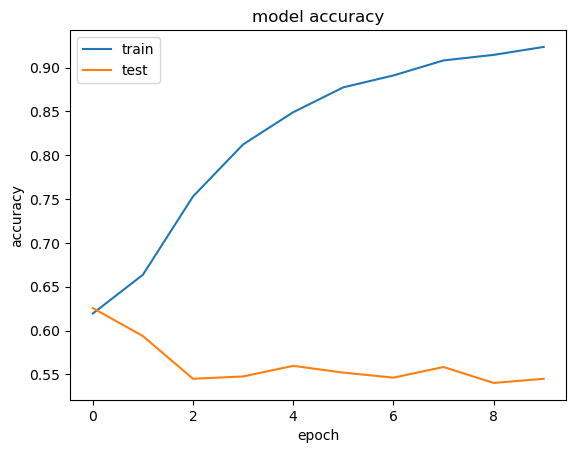

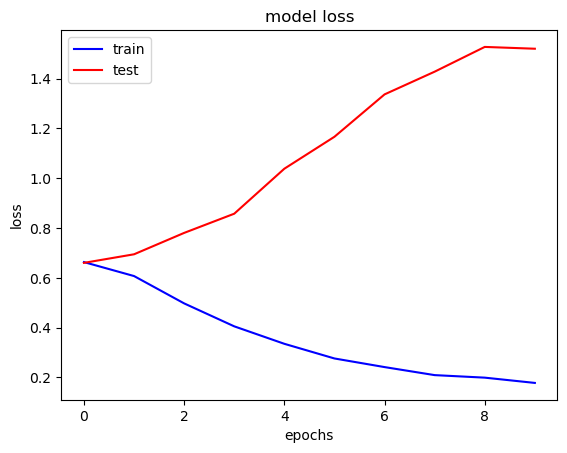

In [182]:
# plots
import matplotlib.pyplot as plt

print(history.history.keys())
#accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#loss
plt.plot(history.history['loss'], 'b', label = 'train')
plt.plot(history.history['val_loss'], 'r',  label = 'test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()